In [43]:
!pip install google-generativeai


In [44]:
from google.colab import userdata
import google.generativeai as genai

YOUTUBE_API_KEY = userdata.get("YT_API_KEY")   # YouTube Data API v3
GEMINI_API_KEY  = userdata.get("GOOGLE_API_KEY")   # Google AI Studio / Gemini

genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel("gemini-1.5-flash")
print("Keys loaded & Gemini ready.")


Keys loaded & Gemini ready.


#Taylor Swift Engagement News: Online Opinion Dynamics
### Author: Long Lin（University of Sydney, Data Science &Business Aanlytics)
Date: August 2025


## 1. Introduction
Taylor Swift's engagement with Travis Kelce sparked intense discussion online.  
This notebook analyzes YouTube comments to understand **public persuasion and sentiment dynamics**, using:

- **Elaboration Likelihood Model (ELM):** distinguishes between *central* (logical, thoughtful) vs. *peripheral* (emotional, superficial) processing routes.
- **Sentiment Analysis:** classifies comments as *positive, neutral, or negative*.  
- **Opinion Dynamics & Economics Analogy:** compares online reactions to market phenomena like *herd behavior, overreaction, and equilibrium*.

**Research questions:**
- Which persuasion route dominates: **central (logical)** vs. **peripheral (emotional)**?  
- Whether sentiment is mainly **positive or negative**, and how it evolves over time.  
- How online opinion dynamics resemble **economic models** such as herding and overreaction.


## 2. Data Collection

I collected comments from **YouTube videos about the engagement news** using the YouTube Data API.  

**Selection criteria:**
- Search query: `"Taylor Swift engagement Travis Kelce"`.  
- Language filter: English (`relevanceLanguage="en"`).  
- Region: US (`regionCode="US"`).  
- Time window: 14 days before analysis date.  
- Videos sorted by relevance, top **5 most viewed videos** were selected.  

**Collected fields:**
- `video_id` (source video)  
- `author` (commenter name)  
- `text` (comment text)  
- `likeCount`, `replyCount`  
- `publishedAt` (timestamp)  

**Raw data:** ~5,700 comments (including replies).  


In [45]:
from googleapiclient.discovery import build
from datetime import datetime, timedelta, timezone
import pandas as pd

youtube = build("youtube", "v3", developerKey=YOUTUBE_API_KEY)

def iso_days_ago(days=7):
    return (datetime.now(timezone.utc) - timedelta(days=days)).isoformat()

def search_videos_with_stats(query="Taylor Swift engagement Travis Kelce",
                             days=14, max_results=30, region="US"):

    search = youtube.search().list(
        part="id,snippet",
        q=query,
        type="video",
        order="relevance",
        maxResults=max_results,
        publishedAfter=iso_days_ago(days),
        relevanceLanguage="en",
        regionCode=region,
        videoDuration="any",
        safeSearch="none"
    ).execute()

    ids = [item["id"]["videoId"] for item in search.get("items", [])]
    if not ids:
        return pd.DataFrame()

    # commentCount
    stats = youtube.videos().list(
        part="snippet,statistics",
        id=",".join(ids)
    ).execute()

    rows = []
    for it in stats.get("items", []):
        st = it.get("statistics", {})
        rows.append({
            "videoId": it["id"],
            "title": it["snippet"]["title"],
            "channel": it["snippet"]["channelTitle"],
            "publishedAt": it["snippet"]["publishedAt"],
            "viewCount": int(st.get("viewCount", 0)) if st.get("viewCount") else 0,
            "commentCount": int(st.get("commentCount", 0)) if st.get("commentCount") else 0,
            "url": f"https://www.youtube.com/watch?v={it['id']}"
        })
    df = pd.DataFrame(rows)
    df = df[df["commentCount"] >= 50].sort_values(["commentCount","viewCount"], ascending=False).reset_index(drop=True)
    return df

candidates = search_videos_with_stats()
print("candidates：", len(candidates))
candidates.head(10)


candidates： 19


,videoId,title,channel,publishedAt,viewCount,commentCount,url
0,06-nt1lQPyg,Taylor Swift and Travis Kelce are engaged,CNN,2025-08-26T18:51:24Z,110331,1284,https://www.youtube.com/watch?v=06-nt1lQPyg
1,NUPPlCFbzR4,Taylor Swift ENGAGED To Travis Kelce,Access Hollywood,2025-08-26T17:32:23Z,259583,800,https://www.youtube.com/watch?v=NUPPlCFbzR4
2,IMTwP8-ARjc,Taylor Swift & Travis Kelce Are Engaged | E! News,E! News,2025-08-26T17:37:41Z,222401,742,https://www.youtube.com/watch?v=IMTwP8-ARjc
3,k8OkXhYQZeE,"BREAKING: Taylor Swift, Travis Kelce announce ...",Fox News,2025-08-26T17:25:16Z,34760,708,https://www.youtube.com/watch?v=k8OkXhYQZeE
4,VNL7kML5-xU,Taylor Swift and Travis Kelce Announce Engagement,Inside Edition,2025-08-26T21:43:34Z,55703,338,https://www.youtube.com/watch?v=VNL7kML5-xU
5,pF0oS9aaEYg,Taylor Swift and Travis Kelce announce engagement,ABC News,2025-08-26T17:24:34Z,498674,310,https://www.youtube.com/watch?v=pF0oS9aaEYg
6,-jW1L1A7N9o,Taylor Swift & Travis Kelce ENGAGED: See The R...,Access Hollywood,2025-08-26T17:43:04Z,65021,160,https://www.youtube.com/watch?v=-jW1L1A7N9o
7,nwNXUTe3FIc,"Taylor Swift, Travis Kelce Engaged: Brittany, ...",E! News,2025-08-26T19:13:37Z,433757,140,https://www.youtube.com/watch?v=nwNXUTe3FIc
8,jNaidJ6BE8o,Taylor Swift and Travis Kelce announce engagement,KTLA 5,2025-08-27T00:44:23Z,14540,127,https://www.youtube.com/watch?v=jNaidJ6BE8o
9,Nbnq1bfNWoc,BREAKING: Taylor Swift engaged to Travis Kelce,LiveNOW from FOX,2025-08-26T20:20:10Z,29565,123,https://www.youtube.com/watch?v=Nbnq1bfNWoc


In [46]:
top = candidates.head(5)
top[["commentCount","viewCount","title","url"]]
video_urls = top["url"].tolist()
video_urls


['https://www.youtube.com/watch?v=06-nt1lQPyg',
 'https://www.youtube.com/watch?v=NUPPlCFbzR4',
 'https://www.youtube.com/watch?v=IMTwP8-ARjc',
 'https://www.youtube.com/watch?v=k8OkXhYQZeE',
 'https://www.youtube.com/watch?v=VNL7kML5-xU']

In [47]:
from googleapiclient.discovery import build
from urllib.parse import urlparse, parse_qs
import pandas as pd

# Extract video ID from YouTube URL
def extract_video_id(url_or_id: str) -> str:
    if "youtube.com" in url_or_id or "youtu.be" in url_or_id:
        u = urlparse(url_or_id)
        if u.netloc == "youtu.be":
            return u.path.lstrip("/")
        return parse_qs(u.query).get("v", [""])[0]
    return url_or_id

# Fetch comments (including replies)
def fetch_comments_with_replies(video_id: str, api_key: str, max_pages=60, order="time"):
    yt = build("youtube", "v3", developerKey=api_key)
    req = yt.commentThreads().list(
        part="snippet,replies",     # request both top-level comments and replies
        videoId=video_id,
        maxResults=100,             # each page returns up to 100 comments
        textFormat="plainText",
        order=order                 # "time" = latest first, "relevance" = default ranking
    )

    rows, pages = [], 0
    while req and pages < max_pages:
        res = req.execute()

        for it in res.get("items", []):
            # --- Top-level comment ---
            top = it["snippet"]["topLevelComment"]["snippet"]
            rows.append({
                "video_id": video_id,
                "level": "top",  # mark as top-level
                "author": top.get("authorDisplayName"),
                "text": (top.get("textDisplay") or "").strip(),
                "likeCount": int(top.get("likeCount", 0) or 0),
                "publishedAt": top.get("publishedAt"),
                "replyCount": int(it["snippet"].get("totalReplyCount", 0) or 0),
            })

            # Replies under this comment ---
            for r in it.get("replies", {}).get("comments", []):
                rs = r.get("snippet", {})
                rows.append({
                    "video_id": video_id,
                    "level": "reply",  # mark as reply
                    "author": rs.get("authorDisplayName"),
                    "text": (rs.get("textDisplay") or "").strip(),
                    "likeCount": int(rs.get("likeCount", 0) or 0),
                    "publishedAt": rs.get("publishedAt"),
                    "replyCount": 0,  # replies don't have sub-replies in this API
                })

        # go to next page
        req = yt.commentThreads().list_next(req, res)
        pages += 1

    df = pd.DataFrame(rows)
    if not df.empty:
        # optional: light deduplication by (author, text)
        df = df[df["text"] != ""].drop_duplicates(subset=["author","text"]).reset_index(drop=True)
    return df


# Run for multiple videos ---
frames = []
for url in video_urls:
    vid = extract_video_id(url)
    print("Fetching:", vid)
    frames.append(fetch_comments_with_replies(vid, YOUTUBE_API_KEY, max_pages=60, order="time"))

raw_df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
print("Total comments fetched (including replies):", len(raw_df))
raw_df.head(3)



Fetching: 06-nt1lQPyg
Fetching: NUPPlCFbzR4
Fetching: IMTwP8-ARjc
Fetching: k8OkXhYQZeE
Fetching: VNL7kML5-xU
Total comments fetched (including replies): 3444


,video_id,level,author,text,likeCount,publishedAt,replyCount
0,06-nt1lQPyg,top,@mackenziesplanet,Taylor's life is the real-life fairytale ❤,0,2025-08-29T05:00:51Z,0
1,06-nt1lQPyg,top,@alceratops6853,As a guy who thinks that Taylor is currently o...,0,2025-08-29T04:08:48Z,0
2,06-nt1lQPyg,top,@timsin2978,make beybees...,0,2025-08-29T02:35:11Z,0


In [48]:
raw_df.to_csv("taylor_engagement_comments.csv", index=False)
print("Saved to taylor_engagement_comments.csv")

Saved to taylor_engagement_comments.csv


## 3. Data Cleaning & Preprocessing

Before labeling and analysis, I performed cleaning steps:

1. **Remove duplicates** (same text repeated).  
2. **Drop spam & irrelevant entries** (e.g., only emojis, ads, or links).  
3. **Normalize text** (lowercase, strip whitespace).  
4. **Keep English only** (non-English comments filtered by language detection).  

This ensures I analyze genuine, unique user reactions.

In [49]:
# Load & basic cleaning ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

df = pd.read_csv("taylor_engagement_comments.csv")

# Ensure essential columns exist
expected_cols = {"text","publishedAt","likeCount","level","video_id","author"}
missing = expected_cols - set(df.columns)
print("Missing columns:", missing)  # just for info

# Parse time and sort
df["publishedAt"] = pd.to_datetime(df["publishedAt"], errors="coerce", utc=True)
df = df.dropna(subset=["text","publishedAt"]).sort_values("publishedAt").reset_index(drop=True)

# Light cleaning
def clean_text(s):
    s = str(s)
    s = s.replace("\n"," ").strip()
    return s
df["text"] = df["text"].apply(clean_text)

# Basic summary
print("Rows:", len(df))
print(df[["level","likeCount"]].describe(include="all"))
df.head(3)


Missing columns: set()
Rows: 3444
       level    likeCount
count   3444  3444.000000
unique     2          NaN
top      top          NaN
freq    2518          NaN
mean     NaN     2.739257
std      NaN    12.992299
min      NaN     0.000000
25%      NaN     0.000000
50%      NaN     0.000000
75%      NaN     1.000000
max      NaN   350.000000


,video_id,level,author,text,likeCount,publishedAt,replyCount
0,k8OkXhYQZeE,top,@BABALAGAJIGAPOO,Who cares!!,2,2025-08-26 17:26:15+00:00,1
1,k8OkXhYQZeE,top,@kingcallumjessislipwinners9388,No one cares,1,2025-08-26 17:26:26+00:00,1
2,k8OkXhYQZeE,top,@ULTIMATUM1488,WHY... IS THIS... A VIDEO?,0,2025-08-26 17:26:34+00:00,1


## 4. Automated Labeling (Gemini)

I used **Gemini-1.5-Flash** to automatically assign two labels:

- **ELM path**:  
  - *Central*: analytical, logical, providing reasons.  
  - *Peripheral*: emotional, jokes, superficial, or slogan-like.  

- **Sentiment**:  
  - *Positive*, *Neutral*, *Negative*.  

Example:  
- “Congrats to Taylor and Travis! ❤️” → `peripheral / positive`.  
- “They’ll be divorced in 5 years.” → `central / negative`.  

In [51]:
# Gemini classification (ELM + sentiment)
!pip install -q google-generativeai
import google.generativeai as genai

# Configure Gemini
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GOOGLE_API_KEY")  # make sure the name matches your Secret
genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel("gemini-1.5-flash")

import json, time
from tqdm import tqdm

SYSTEM_HINT = """You are a research assistant.
Classify each YouTube comment on two axes:
1) ELM Path: "central" (rational, factual, evidence-based) OR "peripheral" (emotional, affective, emojis/fandom).
2) Sentiment: "positive", "neutral", or "negative".
Return strict JSON list:
[{"i": <row_index>, "path": "central|peripheral", "sent": "positive|neutral|negative"}]
No explanations."""

def classify_batch(texts, start_idx=0, retries=3):
    prompt = "Comments:\n" + "\n".join([f"[{i+start_idx}] {t}" for i,t in enumerate(texts)]) \
             + "\n\nReturn JSON ONLY as specified."
    for _ in range(retries):
        try:
            resp = model.generate_content([SYSTEM_HINT, prompt])
            content = resp.text.strip()
            s = content.find("["); e = content.rfind("]")
            return json.loads(content[s:e+1])
        except Exception as e:
            time.sleep(1.0)
    return []

def classify_df(df_in, text_col="text", batch_size=40, sample_n=None, seed=42):
    dfc = df_in.copy()
    if sample_n:
        dfc = dfc.sample(min(sample_n, len(dfc)), random_state=seed).reset_index(drop=True)
    dfc["elm_path"] = None
    dfc["sentiment"] = None
    for i in tqdm(range(0, len(dfc), batch_size)):
        batch = dfc.loc[i:i+batch_size-1, text_col].astype(str).tolist()
        preds = classify_batch(batch, start_idx=i)
        for r in preds:
            j = r.get("i")
            if j is not None and j < len(dfc):
                dfc.at[j, "elm_path"] = r.get("path")
                dfc.at[j, "sentiment"] = r.get("sent")
    return dfc.dropna(subset=["elm_path","sentiment"]).reset_index(drop=True)

# Run classification (adjust sample_n to control cost/time, or set None for all)
labeled = classify_df(df, sample_n=None)  # or sample_n=1200 to go faster
print("Labeled rows:", len(labeled))
labeled[["text","elm_path","sentiment"]].head(5)


100%|██████████| 87/87 [05:35<00:00,  3.86s/it]

Labeled rows: 40


,text,elm_path,sentiment
0,​@@TexRay1836womp womp womp😂😂😂,peripheral,negative
1,Hey siri play Taylor Swift oh my God I’ve been...,peripheral,positive
2,@@benbowles8003 Either way it's fun.,central,positive
3,Congratulations 🎉,peripheral,positive
4,Deport them both!,peripheral,negative


In [57]:
import pandas as pd
labeled = pd.read_csv("taylor_labeled_final.csv")

## 5. Descriptive Statistics  

I first look at the overall distribution of persuasion routes and sentiment:  

- **ELM Path**: About **80%** of comments followed the *peripheral route*, while only ~20% were *central*.  
  → This shows that most users reacted in a quick, emotional way (jokes, insults, cheerleading), rather than through logical reasoning.  

- **Sentiment**: **Negative comments dominated**, followed by positive, with neutral being the smallest group.  
  → Although engagement news typically triggers excitement, criticism and sarcasm outweighed support in volume.  



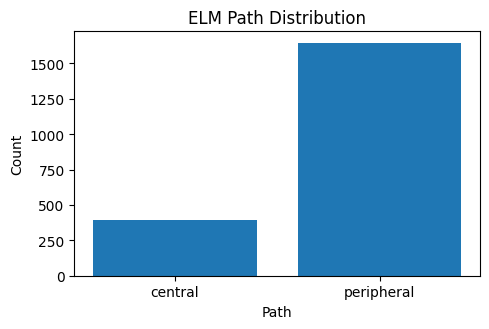

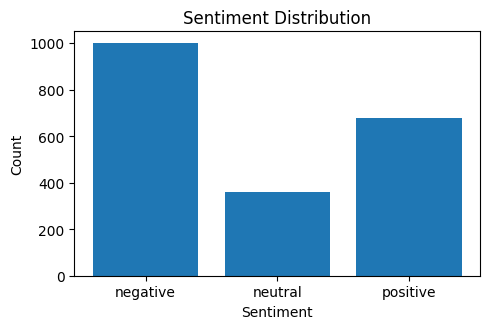

level
top      1660
reply     380
Name: count, dtype: int64


In [58]:
# Descriptives & quick visuals
from collections import Counter

def plot_bar(series, title, xlabel, ylabel):
    c = Counter(series.dropna())
    xs, ys = zip(*sorted(c.items(), key=lambda x:x[0]))
    plt.figure(figsize=(5,3.4))
    plt.bar(xs, ys)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

plot_bar(labeled["elm_path"],  "ELM Path Distribution", "Path", "Count")
plot_bar(labeled["sentiment"], "Sentiment Distribution", "Sentiment", "Count")

# Top vs reply split (optional)
if "level" in labeled.columns:
    print(labeled["level"].value_counts())


## 6. Temporal Dynamics  

I examined how sentiment evolved over time:  

- **Bayesian updating of positivity**:  
  Positivity started very high in the first waves of comments (excitement and celebration), but steadily declined as more critical voices appeared. Eventually, negativity stabilized as the dominant tone.  
  → This pattern resembles *overreaction → correction → equilibrium* in economic dynamics.  

- **Hourly trend**:  
  When aggregated by hour, positivity consistently decreased, showing a cooling-off effect as discussions matured.  

- **Early vs late (herding behavior)**:  
  - Early positive rate: ~45%  
  - Late positive rate: ~27%  
  - Late comments matched the early majority class ~73% of the time.  
  → This suggests **herding behavior**: later participants aligned with the majority sentiment, which had shifted toward negativity.  


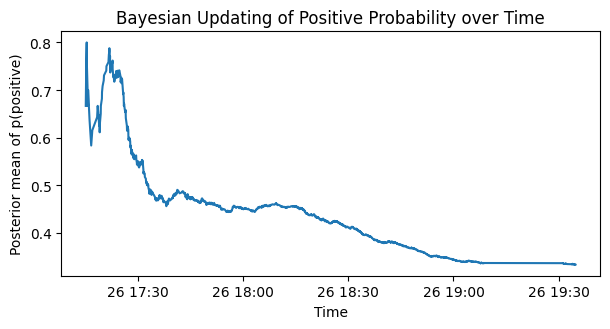

/tmp/ipython-input-3809591925.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  labeled["hour"] = labeled["publishedAt"].dt.floor("H")


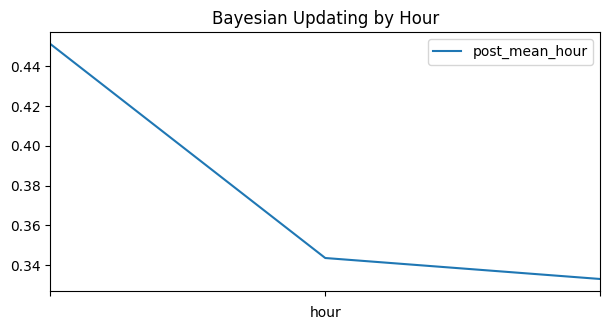

In [59]:
# Bayesian updating for positive probability over time
# Mark positive = 1 else 0
labeled = labeled.sort_values("publishedAt").reset_index(drop=True)
labeled["y_pos"] = (labeled["sentiment"].str.lower() == "positive").astype(int)

alpha0, beta0 = 1.0, 1.0  # uniform prior
cum_pos = labeled["y_pos"].cumsum()
t = np.arange(1, len(labeled)+1)
post_mean = (alpha0 + cum_pos) / (alpha0 + beta0 + t)

plt.figure(figsize=(6.2,3.4))
plt.plot(labeled["publishedAt"], post_mean)
plt.title("Bayesian Updating of Positive Probability over Time")
plt.xlabel("Time")
plt.ylabel("Posterior mean of p(positive)")
plt.tight_layout()
plt.show()

# You can also compute a rolling posterior by hour/day buckets
labeled["hour"] = labeled["publishedAt"].dt.floor("H")
agg = labeled.groupby("hour")["y_pos"].agg(["sum","count"])
agg["post_mean_hour"] = (alpha0 + agg["sum"].cumsum()) / (alpha0 + beta0 + agg["count"].cumsum())
agg[["post_mean_hour"]].plot(figsize=(6.2,3.4))
plt.title("Bayesian Updating by Hour")
plt.tight_layout()
plt.show()


## 7. Herding Behavior

To test for herding effects:
- **Early comments** were more positive.  
- **Later comments** became increasingly negative.  
- About 73% of late comments followed the early majority trend.  

**Interpretation:** Online discussions showed **herd behavior**, with later users aligning with visible majority sentiment.

In [60]:
# Herding check: early vs late convergence
n = len(labeled)
early = labeled.iloc[: max(50, int(0.2*n))]
late  = labeled.iloc[-max(50, int(0.2*n)) :]

p_early = early["y_pos"].mean()
p_late  = late["y_pos"].mean()
print(f"Early positive rate: {p_early:.3f}")
print(f"Late  positive rate: {p_late:.3f}")
print(f"Difference (late - early): {p_late - p_early:+.3f}")

# Optional: test whether late segment deviates less from the majority class of early segment
majority_early = int(p_early >= 0.5)  # 1 if early majority is positive
late_match = (late["y_pos"] == majority_early).mean()
print(f"Late matching early majority fraction: {late_match:.3f}")


Early positive rate: 0.453
Late  positive rate: 0.267
Difference (late - early): -0.186
Late matching early majority fraction: 0.733


## 8. Variance & Polarization

I measured the **rolling variance of positive sentiment** to capture polarization.  

Findings:
- Variance was **high in the early stage**, showing polarized reactions.  
- Variance declined steadily, suggesting convergence of opinions.  
- Convergence was not neutral, but toward a **shared negative consensus**.   



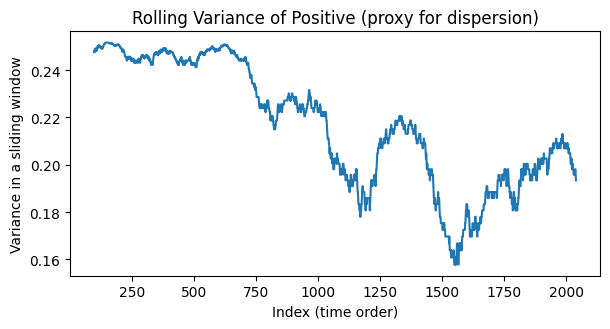

In [61]:
# Rolling variance / entropy trend
win = 200  # rolling window size; adjust to your data scale
roll_mean = labeled["y_pos"].rolling(win, min_periods=win//2).mean()
roll_var  = labeled["y_pos"].rolling(win, min_periods=win//2).var()

plt.figure(figsize=(6.2,3.4))
plt.plot(roll_var.index, roll_var.values)
plt.title("Rolling Variance of Positive (proxy for dispersion)")
plt.xlabel("Index (time order)")
plt.ylabel("Variance in a sliding window")
plt.tight_layout(); plt.show()


## 9. Attention Spikes

I analyzed **comment frequency per hour**.  

Findings:
- A **sharp spike** occurred immediately after the news.  
- Attention then **declined rapidly**, reflecting the short life-cycle of viral events.  

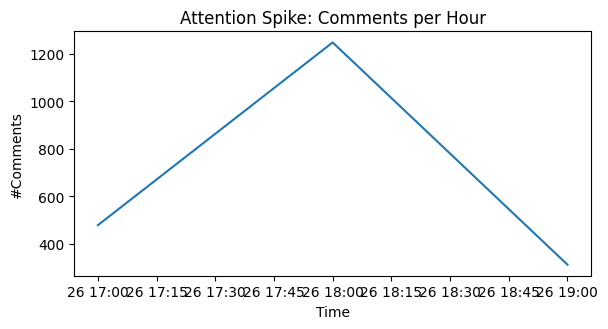

In [62]:
# Attention spike (comments per hour)
cnt = labeled.set_index("publishedAt").resample("60min")["text"].count()
plt.figure(figsize=(6.2,3.4))
plt.plot(cnt.index, cnt.values)
plt.title("Attention Spike: Comments per Hour")
plt.xlabel("Time"); plt.ylabel("#Comments")
plt.tight_layout(); plt.show()


## 10. Engagement: Likes Analysis

I compared **likeCount** across ELM paths and sentiments.  

Findings:
- **Central comments**, though fewer, received **higher average likes**.  
- **Positive comments** attracted more likes than negative ones.  

Interpretation: While negativity dominates in volume, **constructive/positive remarks get stronger engagement rewards**.


In [63]:
# likeCount difference by ELM path / sentiment
import numpy as np

def group_stats(col, by):
    g = labeled.groupby(by)[col].agg(["count","mean","median","std"])
    return g.sort_values("mean", ascending=False)

print("Likes by ELM path:\n", group_stats("likeCount","elm_path"))
print("\nLikes by sentiment:\n", group_stats("likeCount","sentiment"))


Likes by ELM path:
             count       mean  median        std
elm_path                                       
central       396  13.113636     1.0  99.366473
peripheral   1644   4.878345     0.0  30.633379

Likes by sentiment:
            count       mean  median        std
sentiment                                     
neutral      361  10.049861     0.0  95.361667
positive     679   8.927835     0.0  54.174544
negative    1000   3.523000     0.0  13.516144


## 10. Human Validation

I manually audited **100 comments** for reliability.  

- **Sentiment classification**: 99% accuracy, Cohen’s Kappa = 0.98 (almost perfect).  
- **ELM path classification**: 88% accuracy, Cohen’s Kappa = 0.66 (substantial, but harder to classify).  

This shows the sentiment classifier is highly robust, while persuasion route classification remains inherently ambiguous.


In [64]:
import pandas as pd
import numpy as np

np.random.seed(42)
audit = labeled.sample(100).copy()

audit = audit[["text", "elm_path", "sentiment"]]
audit.to_csv("audit_sample.csv", index=False)


In [65]:
import pandas as pd
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

df = pd.read_excel("audit_sample_human.xlsx")

acc_path = accuracy_score(df["human_path"], df["elm_path"])
kappa_path = cohen_kappa_score(df["human_path"], df["elm_path"])

acc_sent = accuracy_score(df["human_sent"], df["sentiment"])
kappa_sent = cohen_kappa_score(df["human_sent"], df["sentiment"])

print(f"Accuracy (ELM path): {acc_path:.2%}, Kappa: {kappa_path:.2f}")
print(f"Accuracy (Sentiment): {acc_sent:.2%}, Kappa: {kappa_sent:.2f}")

print("\nConfusion Matrix - ELM path:")
print(confusion_matrix(df["human_path"], df["elm_path"], labels=["central", "peripheral"]))

print("\nConfusion Matrix - Sentiment:")
print(confusion_matrix(df["human_sent"], df["sentiment"], labels=["negative", "neutral", "positive"]))


Accuracy (ELM path): 88.00%, Kappa: 0.66
Accuracy (Sentiment): 99.00%, Kappa: 0.98

Confusion Matrix - ELM path:
[[16 12]
 [ 0 72]]

Confusion Matrix - Sentiment:
[[49  0  0]
 [ 0 20  1]
 [ 0  0 30]]


## 11. Conclusion

My analysis of YouTube comments surrounding Taylor Swift's engagement provides several insights into **online persuasion and opinion dynamics**:

1. **Peripheral route dominates**:  
   Roughly 80% of comments relied on peripheral cues (emotions, jokes, stereotypes) rather than central reasoning. This suggests that viral celebrity news primarily triggers **emotional reactions** instead of rational debate, consistent with the Elaboration Likelihood Model (ELM).

2. **Negativity outweighs positivity**:  
   Sentiment analysis revealed that negative comments exceeded positive ones. Over time, positivity declined steadily, while negativity increased and stabilized. This dynamic reflects an **overreaction–correction–equilibrium** cycle often observed in economic behavior, but with equilibrium tilted toward negativity.

3. **Herding effects**:  
   Early comments were more positive, but later participants aligned with the growing negative majority. Approximately 73% of late comments matched the early majority sentiment, demonstrating **social conformity and herding behavior**, akin to financial markets where investors follow visible trends.

4. **Polarization and convergence**:  
   Initial variance in sentiment was high, reflecting polarized reactions (some highly supportive, others hostile). As discussion progressed, variance declined, indicating convergence. Importantly, the convergence was **not toward neutrality** but toward a **shared negative consensus**, highlighting the stickiness of negativity in online discourse.

5. **Attention spikes and decay**:  
   Engagement intensity followed a sharp spike immediately after the news, then dropped quickly. This mirrors the **short half-life of online attention**, consistent with prior studies on digital virality.

6. **Engagement asymmetry**:  
   While negative comments dominated in volume, **positive and central comments received disproportionately higher likes**. This indicates that audiences may reward **constructive or thoughtful contributions** even in predominantly negative environments.

**Implications**:  
- From a psychological perspective, emotional and negative cues dominate online persuasion.  
- From an economic perspective, dynamics resemble market behavior: **herding, overreaction, convergence, and short-lived attention cycles**.  
- For platforms or researchers, this highlights the importance of monitoring **polarization and negativity bias**, while recognizing that **reward mechanisms (likes, shares)** may still elevate positive voices.

In sum, Taylor Swift’s engagement served as a natural experiment in **digital collective behavior**, revealing how celebrity events trigger emotional cascades, amplify negative consensus, and follow economic-like patterns of opinion formation in online spaces.
